In [ ]:
###
# Caleb Johnson
#
# Credits to Elvis Saravia for model set-up
###

In [1]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [158]:
import mysql.connector as sql
import pandas as pd

db_connection = sql.connect(host='localhost', database='Thesis', user='guest', password='guest')
try:
    df = pd.read_sql('SELECT * FROM FullTweets where classification = \'highly-anonymous\'', con=db_connection)
    print(df.shape)
    
except:
    print("Error: Read_SQL Fail")

(616077, 5)


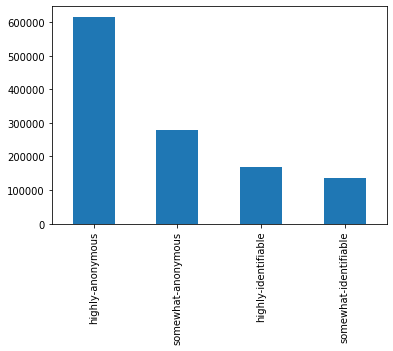

In [34]:
df.classification.value_counts().plot(kind='bar')

In [3]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [5]:
# Loading in our training dataset that has been trained specifically on Tweets
data = load_from_pickle(directory="/Users/calebjohnson/Desktop/BYU/Thesis/Anonymity/merged_training.pkl")

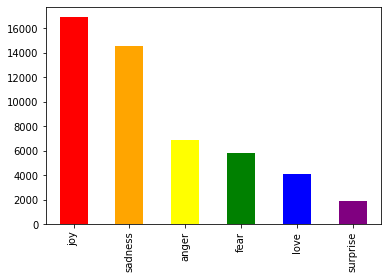

In [6]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000);

data.emotions.value_counts().plot.bar(color = ['red','orange','yellow','green','blue', 'purple'])

In [7]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [8]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aaaa',
 'aaaaaaaaaaaaaaaaggghhhh',
 'aaaaaaand',
 'aaand',
 'aaargh',
 'aab',
 'aacc',
 'aactually',
 'aajao']

In [9]:
# Vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [10]:
# Examples of what is in the input tensors
input_tensor[0:2]

[[12616,
  2041,
  8776,
  5348,
  13554,
  2016,
  22339,
  12547,
  27071,
  1,
  24257,
  18585,
  13968,
  876,
  16213,
  16671,
  21116,
  24540,
  19805,
  24159,
  11589,
  6447,
  24159,
  27178,
  517],
 [11589,
  8769,
  13883,
  12606,
  16618,
  24540,
  1972,
  11851,
  24167,
  21874,
  16352,
  11589,
  26356,
  22547,
  677,
  24167,
  10416,
  26817,
  5864,
  20247,
  15766,
  2598]]

In [11]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

67


In [13]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [14]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [15]:
input_tensor[0:2]

[array([12616,  2041,  8776,  5348, 13554,  2016, 22339, 12547, 27071,
            1, 24257, 18585, 13968,   876, 16213, 16671, 21116, 24540,
        19805, 24159, 11589,  6447, 24159, 27178,   517,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]),
 array([11589,  8769, 13883, 12606, 16618, 24540,  1972, 11851, 24167,
        21874, 16352, 11589, 26356, 22547,   677, 24167, 10416, 26817,
         5864, 20247, 15766,  2598,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

In [16]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [17]:
target_tensor[0:2] 

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [18]:
data[0:2]

,text,emotions,token_size
56544,ive been feeling cranky lately because someone...,anger,25
49335,i feel like its ok to be in the skatepark now ...,joy,22


In [19]:
get_emotion = lambda t: np.argmax(t)

In [20]:
get_emotion(target_tensor[0])

0

In [21]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [22]:
emotion_dict[get_emotion(target_tensor[0])]

'anger'

In [23]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_val))
# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

10000


(40000, 40000, 5000, 5000, 5000, 5000)

In [24]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [25]:
from torch.utils.data import Dataset, DataLoader

In [26]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [27]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [28]:
val_dataset.batch_size

64

In [29]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [30]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([67, 64])
torch.Size([64, 6])


In [32]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [33]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for {} epoch {} sec\n'.format(epoch, time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3033
Epoch 1 Batch 100 Val. Loss 0.2370
Epoch 1 Batch 200 Val. Loss 0.2186
Epoch 1 Batch 300 Val. Loss 0.1242
Epoch 1 Batch 400 Val. Loss 0.0563
Epoch 1 Batch 500 Val. Loss 0.0461
Epoch 1 Batch 600 Val. Loss 0.0286


KeyboardInterrupt: 

In [65]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(27320, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)>

In [150]:
len(input_tensor), len(target_tensor)

(50000, 50000)

In [159]:
# retain only text that contain less that 70 tokens to avoid too much padding
df["token_size"] = df["text"].apply(lambda x: len(x.split(' ')))
df = df.loc[df['token_size'] < 70].copy()

# sampling
df = df.sample(n=50000);

# construct vocab and indexing
fullInputs = ConstructVocab(df["text"].values.tolist())

full_input_tensor = [[fullInputs.word2idx[s] for s in es.split(' ')]  for es in df["text"].values.tolist()]

full_max_length_inp = max_length(full_input_tensor)

in_ten = [pad_sequences(x, full_max_length_inp) for x in full_input_tensor]

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(in_ten, target_tensor, test_size=0.1)


(40000, 10000, 40000, 10000)

In [91]:
df[0:2]

,id,user_id,text,classification,classifier,token_size
660061,2147483647,2147483647,@JPolov I don’t think either extreme has any i...,highly-anonymous,Sherry,14
398493,2147483647,2147483647,@maxinejiji Bkt ang sakit?:&lt;,somewhat-anonymous,Kasey,4


In [160]:
# inplace padding
emotion_test = MyData(input_tensor_train, target_tensor_train)
emotion_test = DataLoader(input_tensor, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

emotion_test.batch_size
len(emotion_test), len(input_tensor_train), len(target_tensor_train)


(781, 45000, 45000)

In [109]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    return X.transpose(0,1), lengths # transpose (batch x seq) to (seq x batch)

In [161]:
embedding_dim = 256
units = 1024
vocab_inp_size = len(fullInputs.word2idx)
target_size = num_emotions

anger = 0
fear = 0
joy = 0
love = 0
sadness = 0
surprise = 0

for batch in emotion_test:        
        predictions,_ = model(batch.permute(1, 0).to(device), lens, device)        
        batchVals = torch.max(predictions, 1)[1].data
        for a in batchVals:
            if a == 0:
                anger += 1
            if a == 1:
                fear += 1
            if a == 2:
                joy += 1
            if a == 3:
                love += 1
            if a == 4:
                sadness += 1
            if a == 5:
                surprise += 1
                
print("Anger: " + str(anger))
print("Fear: " + str(fear))
print("Joy: " + str(joy))
print("Love: " + str(love))
print("Sadness: " + str(sadness))
print("Surprise: " + str(surprise))

Anger: 7694
Fear: 6136
Joy: 15684
Love: 4116
Sadness: 14505
Surprise: 1849


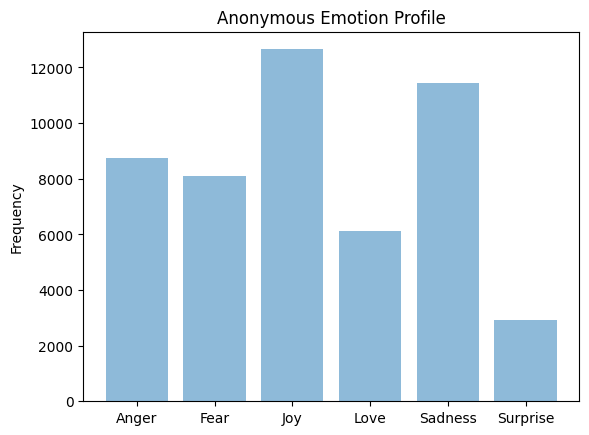

In [166]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Anger', 'Fear', 'Joy', 'Love', 'Sadness', 'Surprise')
y_pos = np.arange(len(objects))
performance = [8759,8106,12652, 6117, 11445, 2905]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Anonymous Emotion Profile')

plt.show()

We are now able to evaluate the results of our classification training

In [64]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  93.0088141025641


This will create the confusion matrix

In [60]:
### Class to Properly Evaluate our Models
class Evaluate():

    def va_dist(cls, prediction, target, va_df, binarizer, name='', silent=False):
        """ Computes distance between actual and prediction through cosine distance """
        va_matrix = va_df.loc[binarizer.classes_][['valence','arousal']].values
        y_va = target.dot(va_matrix)
        F_va = prediction.dot(va_matrix)

        # dist is a one row vector with size of the test data passed(emotion)
        dist = metrics.pairwise.paired_cosine_distances(y_va, F_va)
        res = stats.describe(dist)

        # print by default (if silent=False)
        if not silent:
            print('%s\tmean: %f\tvariance: %f' % (name, res.mean, res.variance))

        return {
            'distances': dist,
            'dist_stat': res
        }

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def predict_class(cls, X_train, y_train, X_test, y_test,
                      pipeline, silent=False, target2=None):
        """ Predicted class,then run some performance evaluation """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        print("predictions computed....")
        return cls.evaluate_class(predictions, y_test, target2, silent)

    def evaluate_prob(cls, prediction, target_rank, target_class, binarizer, va_df, silent=False, target2=None):
        """ Evaluate through probability """
        # Run normal class evaluator
        predict_class = binarizer.classes_[prediction.argmax(axis=1)]
        class_eval = cls.evaluate_class(predict_class, target_class, target2, silent)

        if not silent:
            print('\n - First Emotion Classification Metrics -')
            print('\n - Multiple Emotion rank Metrics -')
            print('VA Cosine Distance')

        classes_dist = [
            (
                emo,
                cls.va_dist(
                    prediction[np.array(target_class) == emo],
                    target_rank[np.array(target_class) == emo],
                    va_df,
                    binarizer,
                    emo,
                    silent)
                ) for emo in binarizer.classes_
        ]
        avg_dist = cls.va_dist(prediction, target_rank, va_df, binarizer, 'avg', silent)

        coverage_error = metrics.coverage_error(target_rank, prediction)
        average_precision_score = metrics.average_precision_score(target_rank, prediction)
        label_ranking_average_precision_score = metrics.label_ranking_average_precision_score(target_rank, prediction)
        label_ranking_loss = metrics.label_ranking_loss(target_rank, prediction)

        # recall at 2
        # obtain top two predictions
        top2_pred = [set([binarizer.classes_[i[0]], binarizer.classes_[i[1]]]) for i in (prediction.argsort(axis=1).T[-2:].T)]
        recall_at_2 = pd.DataFrame(
            [
            t in p for t, p in zip(target_class, top2_pred)
            ], index=target_class, columns=['recall@2']).groupby(level=0).apply(lambda emo: emo.sum()/len(emo))

        # combine target into sets
        if target2:
            union_target = [set(t) for t in zip(target_class, target2)]
        else:
            union_target = [set(t) for t in zip(target_class)]

        # precision at k
        top_k_pred = [
            [set([binarizer.classes_[i] for i in i_list]) for i_list in (prediction.argsort(axis=1).T[-i:].T)]
            for i in range(2, len(binarizer.classes_)+1)]
        precision_at_k = [
            ('p@' + str(k+2), np.array([len(t & p)/(k+2) for t, p in zip(union_target, top_k_pred[k])]).mean())
            for k in range(len(top_k_pred))]

        # do this if silent= False
        if not silent:
            print('\n')
            print(recall_at_2)
            print('\n')
            print('p@k')
            for pk in precision_at_k:
                print(pk[0] + ':\t' + str(pk[1]))
            print('\ncoverage_error: %f' % coverage_error)
            print('average_precision_score: %f' % average_precision_score)
            print('label_ranking_average_precision_score: %f' % label_ranking_average_precision_score)
            print('label_ranking_loss: %f' % label_ranking_loss)

        return {
            'class_eval': class_eval,
            'recall_at_2': recall_at_2.to_dict(),
            'precision_at_2': precision_at_k,
            'classes_dist': classes_dist,
            'avg_dist': avg_dist,
            'coverage_error': coverage_error,
            'average_precision_score': average_precision_score,
            'label_ranking_average_precision_score': label_ranking_average_precision_score,
            'label_ranking_loss': label_ranking_loss
        }


    def predict_prob(cls, X_train, y_train, X_test, y_test, label_test, pipeline, binarizer, va_df, silent=False, target2=None):
        """ Output predcations based on training and labels """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict_proba(X_test)
        pred_to_mlb = [np.where(pipeline.classes_ == emo)[0][0] for emo in binarizer.classes_.tolist()]
        return cls.evaluate_prob(predictions[:,pred_to_mlb], y_test, label_test, binarizer, va_df, silent, target2)


    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[3, 2, 2, 1, 4, 2, 3, 2, 4, 5, 5, 0, 2, 1, 3, 2, 2, 2, 2, 4, 4, 2, 2, 4, 0, 2, 0, 4, 4, 4, 3, 5, 0, 2, 4, 0, 2, 2, 3, 4, 4, 2, 0, 3, 4, 4, 4, 2, 0, 3, 2, 3, 4, 4, 2, 1, 4, 4, 2, 4, 1, 2, 3, 2, 2, 2, 2, 4, 1, 2, 4, 0, 4, 4, 2, 3, 1, 0, 0, 2, 0, 2, 2, 4, 3, 4, 2, 2, 4, 2, 3, 4, 4, 3, 2, 0, 4, 2, 3, 4, 5, 5, 4, 2, 4, 4, 2, 4, 3, 0, 0, 4, 4, 2, 2, 2, 2, 0, 3, 4, 2, 5, 2, 2, 4, 2, 4, 2, 0, 2, 2, 4, 4, 0, 2, 4, 3, 4, 2, 4, 4, 2, 1, 4, 5, 4, 2, 4, 3, 3, 1, 4, 3, 2, 4, 3, 0, 4, 2, 2, 4, 4, 3, 3, 1, 3, 1, 4, 0, 4, 1, 2, 0, 4, 2, 4, 4, 5, 5, 2, 0, 4, 0, 4, 2, 3, 4, 4, 1, 4, 1, 4, 5, 2, 2, 0, 0, 2, 2, 3, 3, 4, 2, 0, 2, 3, 2, 1, 3, 0, 2, 4, 0, 4, 0, 2, 1, 0, 0, 1, 4, 4, 1, 4, 4, 1, 4, 2, 2, 2, 2, 0, 2, 2, 2, 2, 4, 0, 2, 2, 2, 2, 4, 1, 3, 1, 2, 2, 4, 4, 2, 2, 1, 2, 2, 2, 0, 4, 2, 1, 2, 3, 2, 4, 2, 2, 2, 4, 1, 1, 3, 1, 3, 2, 2, 2, 2, 4, 4, 3, 4, 1, 1, 4, 2, 2, 2, 2, 0, 2, 4, 2, 0, 0, 2, 4, 2, 2, 2, 4, 5, 2, 2, 2, 4, 0, 2, 1, 4, 3, 1, 4, 2, 2, 4, 2, 1, 2, 1, 4, 1, 4, 4, 1, 2, 4, 3, 3, 4, 5, 2, 2, 2, 

Default Classification report
              precision    recall  f1-score   support

       anger       0.96      0.92      0.94       674
        fear       0.89      0.90      0.90       580
         joy       0.94      0.95      0.95      1728
        love       0.83      0.84      0.84       418
     sadness       0.96      0.97      0.97      1414
    surprise       0.80      0.78      0.79       178

    accuracy                           0.93      4992
   macro avg       0.90      0.89      0.90      4992
weighted avg       0.93      0.93      0.93      4992


Accuracy:
0.9300881410256411
Correct Predictions:  4643
precision: 0.90
recall: 0.89
f1: 0.90

confusion matrix
 [[ 619   16   12    2   25    0]
 [   8  520    5    1   21   25]
 [   4    3 1642   68    3    8]
 [   0    0   66  352    0    0]
 [  16   18    7    1 1371    1]
 [   0   25   11    1    2  139]]
(row=expected, col=predicted)


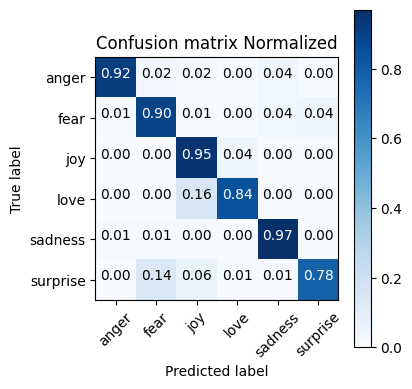

In [141]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p.cpu().detach().numpy())
        
predictions = [np.argmax(p).item() for p in final_predictions]
print(predictions)
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );